# Một cách tiếp cận sử dụng LSTM

Xem phần phân tích cụ thể và tiền xử lí trong file PJ3.ipynb

## 1. Đọc dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn 
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv('./data/vn_news_223_tdlfr.csv')
df.drop(columns=['domain'],inplace=True)
df

,text,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\r...,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",1
...,...,...
218,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,0
219,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,0
220,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,0
221,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,0


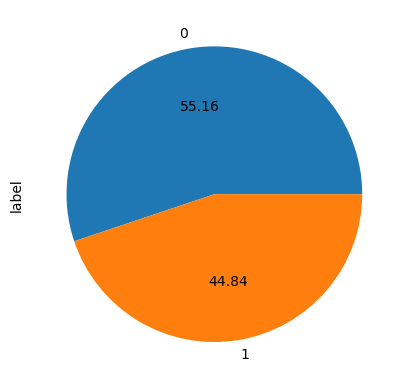

In [3]:
df.label.value_counts().plot(kind='pie', autopct='%.2f');

## Tiền xử lí

Vì dữ liệu nhỏ nên sẽ không có tập val

In [4]:
X_df = df.drop('label', axis=1)
y_df = df['label']
x_train, x_test, y_train, y_test = train_test_split(X_df, 
                                                    y_df, 
                                                    test_size=0.2,
                                                    stratify = y_df, 
                                                    random_state=42)

In [5]:
def preprocess(s):
    s = re.sub(r'[^\w\s]','', s)
    s = re.sub(r'\s+', '',s)
    s = re.sub(r'\d', '', s)
    return s

In [6]:
with open('stopwords/vietnamese-stopwords.txt',encoding='utf-8') as f:
    stopwords = f.readlines()
    stopwords = [word.rstrip() for word in stopwords]

Tokenize các văn bản và padding. Chiều dài tối đa là 1000

In [7]:
def tokenizer(x_train, y_train, x_val, y_val, stop_words):
    word_list = list()
    for sequence in x_train:
        for word in sequence.lower().split():
            word = preprocess(word)
            if word not in stop_words and word !='':
                word_list.append(word)
    
    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)#[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    final_list_train, final_list_test = list(), list()
    for sequence in x_train:
        final_list_train.append([onehot_dict[preprocess(word)] for word in sequence.lower().split()
                                if preprocess(word) in onehot_dict.keys()])
    for sequence in x_val:
        final_list_test.append([onehot_dict[preprocess(word)] for word in sequence.lower().split()
                              if preprocess(word) in onehot_dict.keys()])
    return (np.array(final_list_train, dtype='object'), 
            np.array(y_train), 
            np.array(final_list_test, dtype='object'), 
            np.array(y_test), 
            onehot_dict)

In [8]:
x_train, y_train, x_test, y_test, vocab = tokenizer(x_train.text.to_list(), 
                                             y_train, 
                                             x_test.text.to_list(), 
                                             y_test, 
                                             stopwords)

In [9]:
print(f'Length of vocab: {len(vocab)}')

Length of vocab: 3637


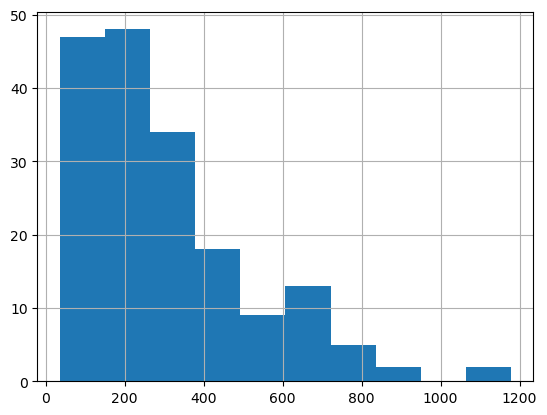

count     178.000000
mean      306.578652
std       211.850995
min        36.000000
25%       147.250000
50%       235.000000
75%       394.750000
max      1178.000000
dtype: float64

In [10]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [11]:
MAX_LEN = 1000
BATCH_SIZE = 32
n_layers = 2
vocab_size = len(vocab) + 1
output_dims = 1
hidden_dims = 256
embedding_dims = 64

In [12]:
def padding(X, max_len):
    features = np.zeros((len(X), max_len),dtype=int)
    for i, sequence in enumerate(X):
        features[i, -len(sequence):] = np.array(sequence)[:max_len]
    return features
x_train_padding = padding(x_train, MAX_LEN)
x_test_padding = padding(x_test, MAX_LEN)

In [13]:
train_data = TensorDataset(torch.from_numpy(x_train_padding), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_padding), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE,drop_last=True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE,drop_last=True)

In [14]:
len(test_dataloader.dataset)

45

In [15]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device('cuda')
    print('GPU available')
else:
    device = torch.device('cpu')
    print('CPU available')

GPU available


## Mô hình LSTM bằng PyTorch

In [16]:
class LSTM(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dims, embedding_dims, dropout_rate = 0.5):
        super(LSTM, self).__init__()
        self.output_dims = output_dims
        self.hidden_dims = hidden_dims
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(self.vocab_size, embedding_dims)
        self.lstm = nn.LSTM(input_size = embedding_dims,
                           hidden_size = self.hidden_dims,
                           num_layers = self.n_layers,
                           batch_first = True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.hidden_dims, self.output_dims)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden_state):
        batch_size = x.size(0)
        embedding = self.embedding(x)
        lstm_out, hidden_state = self.lstm(embedding, hidden_state)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dims)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = out.view(batch_size, -1)
        out = out[:, -1]
        return out, hidden_state
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dims)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dims)).to(device)
        return (h0, c0)

In [17]:
model = LSTM(n_layers, vocab_size, hidden_dims, embedding_dims)
model.to(device)

LSTM(
  (embedding): Embedding(3638, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
summary(model)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─Embedding: 1-1                         232,832
├─LSTM: 1-2                              856,064
├─Dropout: 1-3                           --
├─Linear: 1-4                            257
├─Sigmoid: 1-5                           --
Total params: 1,089,153
Trainable params: 1,089,153
Non-trainable params: 0

In [19]:
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
def accuracy(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred==label.squeeze()).item()

In [20]:
clip = 5
EPOCHS = 200
valid_loss_min = np.Inf

history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}
train_step = len(train_dataloader.dataset) // BATCH_SIZE
test_step = len(test_dataloader.dataset) // BATCH_SIZE

start_time = time.time()
for epoch in range(EPOCHS):
    train_loss = list()
    train_acc = 0
    model.train()
    hidden_state = model.init_hidden(BATCH_SIZE)
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        hidden_state = tuple([each.data for each in hidden_state])
        
        model.zero_grad()
        output, hidden_state = model(inputs, hidden_state)
        
        loss = loss_fn(output.squeeze(), labels.float())
        loss.backward()
        
        train_loss.append(loss.item())
        
        acc = accuracy(output, labels)
        train_acc += acc
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    test_h = model.init_hidden(BATCH_SIZE)
    test_loss = list()
    test_acc = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_dataloader:
            test_h = tuple([each.data for each in test_h])

            inputs, labels = inputs.to(device), labels.to(device)
            output, test_h = model(inputs, test_h)

            loss = loss_fn(output.squeeze(), labels.float())
            test_loss.append(loss.item())

            acc = accuracy(output, labels)
            test_acc += acc
    
    epoch_train_loss = np.mean(train_loss)
    epoch_test_loss = np.mean(test_loss)
    epoch_train_acc = train_acc/(train_step * BATCH_SIZE)
    epoch_test_acc = test_acc/(test_step * BATCH_SIZE)
    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(epoch_test_loss)
    history['train_acc'].append(epoch_train_acc)
    history['test_acc'].append(epoch_test_acc)
    
    print(f'[INFO] EPOCHS: {epoch + 1}/{EPOCHS}')
    print('Train loss: {:.6f}, Test loss: {:.6f}'.format(epoch_train_loss,epoch_test_loss))
    print('Train acc: {:.4f}, Test acc: {:.4f}\n'.format(epoch_train_acc,epoch_test_acc))    

end_time = time.time()
print('[INFO] total time taken to train the model: {:.2f}s'.format(end_time - start_time))

[INFO] EPOCHS: 1/200
Train loss: 0.690227, Test loss: 0.680797
Train acc: 0.5250, Test acc: 0.5625

[INFO] EPOCHS: 2/200
Train loss: 0.666919, Test loss: 0.678392
Train acc: 0.5687, Test acc: 0.5625

[INFO] EPOCHS: 3/200
Train loss: 0.616914, Test loss: 0.694744
Train acc: 0.6000, Test acc: 0.5625

[INFO] EPOCHS: 4/200
Train loss: 0.505688, Test loss: 0.704311
Train acc: 0.8063, Test acc: 0.6250

[INFO] EPOCHS: 5/200
Train loss: 0.403430, Test loss: 0.688101
Train acc: 0.8500, Test acc: 0.5625

[INFO] EPOCHS: 6/200
Train loss: 0.339047, Test loss: 0.791484
Train acc: 0.8125, Test acc: 0.6250

[INFO] EPOCHS: 7/200
Train loss: 0.224726, Test loss: 0.852732
Train acc: 0.9187, Test acc: 0.7188

[INFO] EPOCHS: 8/200
Train loss: 0.167318, Test loss: 1.077741
Train acc: 0.9625, Test acc: 0.6875

[INFO] EPOCHS: 9/200
Train loss: 0.087762, Test loss: 1.079411
Train acc: 0.9938, Test acc: 0.7188

[INFO] EPOCHS: 10/200
Train loss: 0.027616, Test loss: 1.219929
Train acc: 0.9938, Test acc: 0.6875


[INFO] EPOCHS: 83/200
Train loss: 0.377033, Test loss: 0.665750
Train acc: 0.9625, Test acc: 0.6562

[INFO] EPOCHS: 84/200
Train loss: 0.384277, Test loss: 0.729228
Train acc: 0.8812, Test acc: 0.5312

[INFO] EPOCHS: 85/200
Train loss: 0.336773, Test loss: 0.657837
Train acc: 0.9500, Test acc: 0.6250

[INFO] EPOCHS: 86/200
Train loss: 0.350677, Test loss: 0.616677
Train acc: 0.9313, Test acc: 0.7188

[INFO] EPOCHS: 87/200
Train loss: 0.247709, Test loss: 0.633600
Train acc: 0.9625, Test acc: 0.6875

[INFO] EPOCHS: 88/200
Train loss: 0.216627, Test loss: 0.624557
Train acc: 0.9812, Test acc: 0.7188

[INFO] EPOCHS: 89/200
Train loss: 0.182389, Test loss: 0.656732
Train acc: 0.9812, Test acc: 0.7188

[INFO] EPOCHS: 90/200
Train loss: 0.164355, Test loss: 0.682286
Train acc: 0.9875, Test acc: 0.7500

[INFO] EPOCHS: 91/200
Train loss: 0.134900, Test loss: 0.717867
Train acc: 0.9875, Test acc: 0.7500

[INFO] EPOCHS: 92/200
Train loss: 0.119382, Test loss: 0.788417
Train acc: 0.9875, Test acc

[INFO] EPOCHS: 164/200
Train loss: 0.004001, Test loss: 2.034936
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 165/200
Train loss: 0.003861, Test loss: 2.045160
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 166/200
Train loss: 0.003926, Test loss: 2.054004
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 167/200
Train loss: 0.003975, Test loss: 2.062150
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 168/200
Train loss: 0.003715, Test loss: 2.069983
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 169/200
Train loss: 0.004026, Test loss: 2.077599
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 170/200
Train loss: 0.003889, Test loss: 2.084620
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 171/200
Train loss: 0.003368, Test loss: 2.092235
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 172/200
Train loss: 0.003039, Test loss: 2.100073
Train acc: 1.0000, Test acc: 0.5938

[INFO] EPOCHS: 173/200
Train loss: 0.002986, Test loss: 2.107826
Train acc: 1.0000

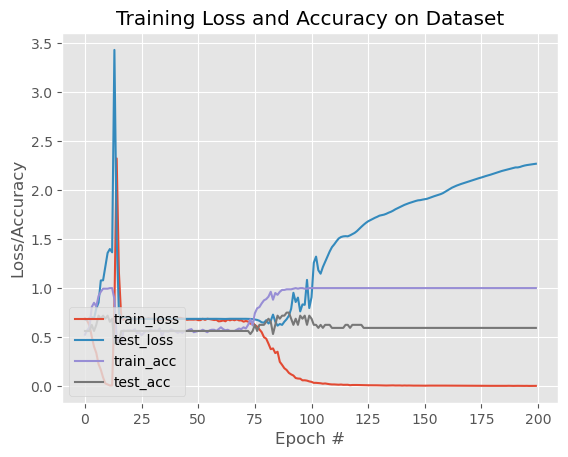

In [21]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left");

In [22]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess(word)] for word in text.split() 
                         if preprocess(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad = torch.from_numpy(padding(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [23]:
i = 0
print('Predict: ',predict_text(df.text[i]))
print('Actual: ',df.label[i])

Predict:  0.004681738093495369
Actual:  1


Mô hình bị overfitting???